In [11]:
!pip install --upgrade opendatasets
import opendatasets as od
print(od.version())


0.1.22


In [12]:
dataset_url='https://www.kaggle.com/competitions/cafa-6-protein-function-prediction/data'

In [13]:
import os
data_path = "/kaggle/input/cafa-6-protein-function-prediction"
print("Files in dataset:", os.listdir(data_path))


Files in dataset: ['sample_submission.tsv', 'IA.tsv', 'Test', 'Train']


**Check What’s Actually Inside the Dataset Folde**


**Understanding the Dataset StructureWe examined:Folder layout (Train/, Test/)What each file contains (FASTA, TSV, OBO)How they relate to each other➡️ Goal: know what inputs, labels, and metadata we have.**


In [14]:
import os

BASE_PATH = "/kaggle/input/cafa-6-protein-function-prediction"
print(os.listdir(BASE_PATH))


['sample_submission.tsv', 'IA.tsv', 'Test', 'Train']



**Understanding the Protein AnnotationsWe loaded:train_terms.tsv — 537,027 rowsColumns: EntryID, term, aspectObserved that proteins can have multiple labels across 3 GO sub-ontologies (F, P, C)➡️ Goal: understand the label structure (multi-label classification problem).**


In [15]:
import os

BASE_PATH = "/kaggle/input/cafa-6-protein-function-prediction"

TRAIN_PATH = os.path.join(BASE_PATH, "Train")
TEST_PATH = os.path.join(BASE_PATH, "Test")

print("Train files:", os.listdir(TRAIN_PATH))
print("Test files:", os.listdir(TEST_PATH))


Train files: ['train_terms.tsv', 'train_sequences.fasta', 'train_taxonomy.tsv', 'go-basic.obo']
Test files: ['testsuperset.fasta', 'testsuperset-taxon-list.tsv']



**Understanding the Biological OntologyWe parsed:go-basic.obo → 40,122 nodes (terms), 77,229 edges (relationships)Learned how GO terms connect via is_a and other relations➡️ Goal: know that the label space isn’t flat — it’s hierarchical, and we can later leverage that (e.g., Graph Neural Networks or ontology-based regularization).**


In [16]:
import pandas as pd
import os

train_terms_path = os.path.join(TRAIN_PATH, "train_terms.tsv")

# Load the TSV file (tab-separated)
train_terms = pd.read_csv(train_terms_path, sep="\t")

# Display first few rows and shape
print("✅ train_terms loaded successfully!")
print("Shape:", train_terms.shape)
train_terms.head()


✅ train_terms loaded successfully!
Shape: (537027, 3)


,EntryID,term,aspect
0,Q5W0B1,GO:0000785,C
1,Q5W0B1,GO:0004842,F
2,Q5W0B1,GO:0051865,P
3,Q5W0B1,GO:0006275,P
4,Q5W0B1,GO:0006513,P



**Next: Parse the GO Ontology Graph (go-basic.obo)This file describes how the GO terms are related to each other —like a knowledge graph of biological concepts.We’ll parse it with the Python library obonet, which reads .obo files into a NetworkX grap**


In [17]:
!pip install obonet networkx

import obonet
import networkx as nx
import os

obo_path = os.path.join(TRAIN_PATH, "go-basic.obo")

# Load the ontology graph
print("Loading GO ontology...")
go_graph = obonet.read_obo(obo_path)
print("✅ GO graph loaded!")

# Basic info
print("Total GO terms (nodes):", go_graph.number_of_nodes())
print("Total relationships (edges):", go_graph.number_of_edges())

# Find the three ontology roots
roots = [n for n, d in go_graph.nodes(data=True) if 'is_a' not in d]
print("\nExample GO term node:")
first_node = list(go_graph.nodes(data=True))[0]
print(first_node)


Loading GO ontology...
✅ GO graph loaded!
Total GO terms (nodes): 40122
Total relationships (edges): 77229

Example GO term node:
('GO:0000001', {'name': 'mitochondrion inheritance', 'namespace': 'biological_process', 'def': '"The distribution of mitochondria, including the mitochondrial genome, into daughter cells after mitosis or meiosis, mediated by interactions between mitochondria and the cytoskeleton." [GOC:mcc, PMID:10873824, PMID:11389764]', 'synonym': ['"mitochondrial inheritance" EXACT []'], 'is_a': ['GO:0048308', 'GO:0048311']})


Aspect distribution:
aspect
P    250805
C    157770
F    128452
Name: count, dtype: int64


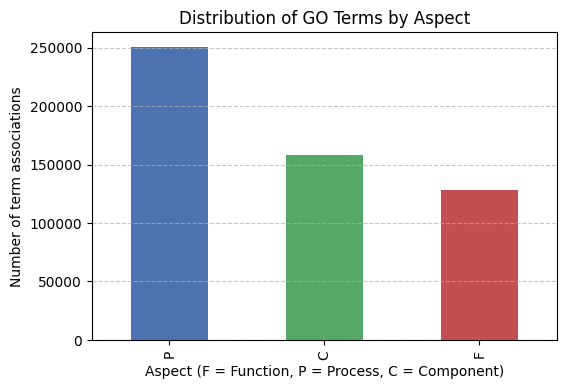

In [18]:
import matplotlib.pyplot as plt

# Count GO terms by aspect
aspect_counts = train_terms['aspect'].value_counts()

print("Aspect distribution:")
print(aspect_counts)

# Plot
plt.figure(figsize=(6,4))
aspect_counts.plot(kind='bar', color=['#4C72B0','#55A868','#C44E52'])
plt.title('Distribution of GO Terms by Aspect')
plt.xlabel('Aspect (F = Function, P = Process, C = Component)')
plt.ylabel('Number of term associations')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



**Analyze GO Term Distribution by AspectThis tells us which ontology contributes the most labels — helpful because models may need separate handling for BP, MF, and CC.**


Average number of GO terms per protein: 6.52
Median number of GO terms per protein: 4.0
Max number of GO terms for a single protein: 233


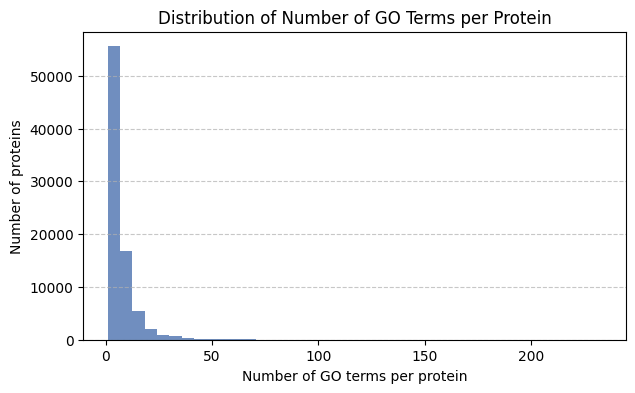

In [19]:
# Count number of unique GO terms per protein
terms_per_protein = train_terms.groupby('EntryID')['term'].nunique()

print("Average number of GO terms per protein:", round(terms_per_protein.mean(), 2))
print("Median number of GO terms per protein:", terms_per_protein.median())
print("Max number of GO terms for a single protein:", terms_per_protein.max())

# Visualize distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(terms_per_protein, bins=40, color='#4C72B0', alpha=0.8)
plt.title("Distribution of Number of GO Terms per Protein")
plt.xlabel("Number of GO terms per protein")
plt.ylabel("Number of proteins")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



**Explore Protein SequencesWe’ll check:Number of sequencesSequence length distributionTypical amino acid composition**


In [20]:
!pip install biopython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.1 MB/s eta 0:00:0000:0100:01


✅ Total sequences loaded: 82404
                     EntryID  \
0  sp|A0A0C5B5G6|MOTSC_HUMAN   
1      sp|A0JNW5|BLT3B_HUMAN   
2      sp|A0JP26|POTB3_HUMAN   
3      sp|A0PK11|CLRN2_HUMAN   
4      sp|A1A4S6|RHG10_HUMAN   

                                            Sequence  Length  
0                                   MRWQEMGYIFYPRKLR      16  
1  MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...    1464  
2  MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...     581  
3  MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...     232  
4  MGLQPLEFSDCYLDSPWFRERIRAHEAELERTNKFIKELIKDGKNL...     786  


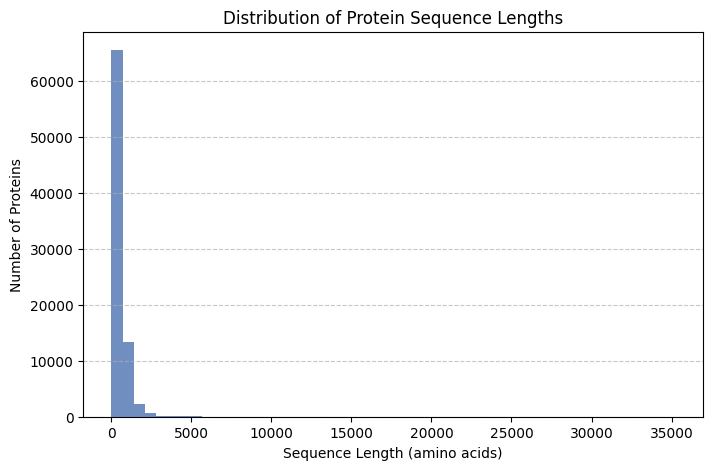

In [21]:
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt

# Load the FASTA sequences
train_sequences_path = os.path.join(TRAIN_PATH, "train_sequences.fasta")

# Read sequences
sequences = list(SeqIO.parse(train_sequences_path, "fasta"))

# Convert to DataFrame
seq_df = pd.DataFrame({
    "EntryID": [seq.id for seq in sequences],
    "Sequence": [str(seq.seq) for seq in sequences],
    "Length": [len(seq.seq) for seq in sequences]
})

print("✅ Total sequences loaded:", len(seq_df))
print(seq_df.head())

# Plot sequence length distribution
plt.figure(figsize=(8,5))
plt.hist(seq_df["Length"], bins=50, color="#4C72B0", alpha=0.8)
plt.title("Distribution of Protein Sequence Lengths")
plt.xlabel("Sequence Length (amino acids)")
plt.ylabel("Number of Proteins")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [22]:
# CELL 1: setup
import os
BASE_PATH = "/kaggle/input/cafa-6-protein-function-prediction"
TRAIN_PATH = os.path.join(BASE_PATH, "Train")
TEST_PATH  = os.path.join(BASE_PATH, "Test")

print("TRAIN_PATH:", TRAIN_PATH)
print("TEST_PATH :", TEST_PATH)

# common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO

pd.options.display.max_columns = 200


TRAIN_PATH: /kaggle/input/cafa-6-protein-function-prediction/Train
TEST_PATH : /kaggle/input/cafa-6-protein-function-prediction/Test


In [23]:
# CELL 2: load sequences and terms if not already loaded
train_fasta_path = os.path.join(TRAIN_PATH, "train_sequences.fasta")
train_terms_path = os.path.join(TRAIN_PATH, "train_terms.tsv")

sequences = list(SeqIO.parse(train_fasta_path, "fasta"))
print("Total sequences parsed:", len(sequences))

# create seq dataframe
seq_df = pd.DataFrame({
    "EntryID": [s.id for s in sequences],
    "Sequence": [str(s.seq) for s in sequences],
    "Length": [len(s.seq) for s in sequences]
})

train_terms = pd.read_csv(train_terms_path, sep="\t")
print("train_terms shape:", train_terms.shape)
train_terms.head()


Total sequences parsed: 82404
train_terms shape: (537027, 3)


,EntryID,term,aspect
0,Q5W0B1,GO:0000785,C
1,Q5W0B1,GO:0004842,F
2,Q5W0B1,GO:0051865,P
3,Q5W0B1,GO:0006275,P
4,Q5W0B1,GO:0006513,P


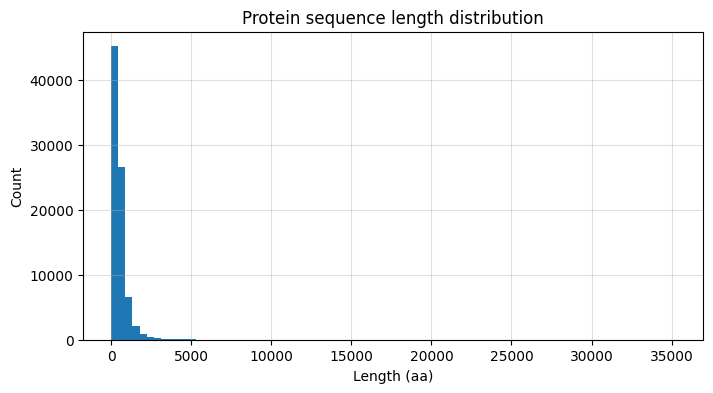

Length stats (min, 25%, median, mean, 75%, max):
[3.0000e+00 2.5000e+02 4.0900e+02 6.3000e+02 3.5213e+04]
Mean length: 525.7882869763604


In [24]:
# CELL 3: length distribution
plt.figure(figsize=(8,4))
plt.hist(seq_df["Length"], bins=80)
plt.title("Protein sequence length distribution")
plt.xlabel("Length (aa)")
plt.ylabel("Count")
plt.grid(alpha=0.4)
plt.show()

# Print some stats
print("Length stats (min, 25%, median, mean, 75%, max):")
print(np.percentile(seq_df["Length"], [0,25,50,75,100]))
print("Mean length:", seq_df["Length"].mean())


In [25]:
# CELL 4: compute AAC
AA_LIST = list("ACDEFGHIKLMNPQRSTVWY")  # 20 standard amino acids

def aa_composition(seq):
    seq = seq.upper()
    L = len(seq)
    counts = {aa: 0 for aa in AA_LIST}
    for ch in seq:
        if ch in counts:
            counts[ch] += 1
    # return frequencies (counts / length)
    if L == 0:
        freqs = {aa: 0.0 for aa in AA_LIST}
    else:
        freqs = {aa: counts[aa]/L for aa in AA_LIST}
    freqs["seq_length"] = L
    return freqs

# apply (be patient — 82k sequences)
aac_rows = [aa_composition(s) for s in seq_df["Sequence"].values]
aac_df = pd.DataFrame(aac_rows, index=seq_df["EntryID"].values).reset_index().rename(columns={"index":"EntryID"})
aac_df.shape, aac_df.head()


((82404, 22),
                      EntryID         A         C         D         E  \
 0  sp|A0A0C5B5G6|MOTSC_HUMAN  0.000000  0.000000  0.000000  0.062500   
 1      sp|A0JNW5|BLT3B_HUMAN  0.049863  0.017077  0.060109  0.066940   
 2      sp|A0JP26|POTB3_HUMAN  0.053356  0.037866  0.063683  0.092943   
 3      sp|A0PK11|CLRN2_HUMAN  0.107759  0.021552  0.021552  0.051724   
 4      sp|A1A4S6|RHG10_HUMAN  0.058524  0.013995  0.047074  0.090331   
 
           F         G         H         I         K         L         M  \
 0  0.062500  0.062500  0.000000  0.062500  0.062500  0.062500  0.125000   
 1  0.035519  0.037568  0.032787  0.057377  0.071038  0.099044  0.023907   
 2  0.015491  0.056799  0.034423  0.036145  0.092943  0.104991  0.030981   
 3  0.064655  0.073276  0.021552  0.081897  0.043103  0.133621  0.017241   
 4  0.053435  0.049618  0.026718  0.045802  0.077608  0.090331  0.022901   
 
           N         P         Q         R         S         T         V  \
 0  0.000000

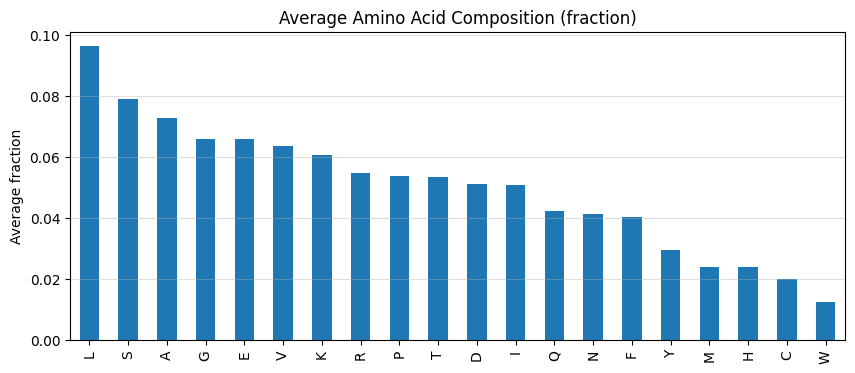

Top 5 amino acids by average fraction:
L    0.096265
S    0.079044
A    0.072721
G    0.065794
E    0.065687
dtype: float64


In [26]:
# CELL 5: average composition across dataset
mean_comp = aac_df[AA_LIST].mean().sort_values(ascending=False)

plt.figure(figsize=(10,4))
mean_comp.plot(kind="bar")
plt.title("Average Amino Acid Composition (fraction)")
plt.ylabel("Average fraction")
plt.grid(axis='y', alpha=0.4)
plt.show()

print("Top 5 amino acids by average fraction:")
print(mean_comp.head(5))


In [27]:
# CELL 6: match check
seq_ids = set(seq_df["EntryID"])
term_ids = set(train_terms["EntryID"].unique())

print("Total unique sequences:", len(seq_ids))
print("Total unique labeled EntryIDs:", len(term_ids))
print("Sequences with labels:", len(seq_ids & term_ids))
print("Labeled IDs without sequence file:", len(term_ids - seq_ids))
print("Sequences without labels:", len(seq_ids - term_ids))

# Show a small sample of unmatched IDs (if any)
list(term_ids - seq_ids)[:10], list(seq_ids - term_ids)[:10]


Total unique sequences: 82404
Total unique labeled EntryIDs: 82404
Sequences with labels: 0
Labeled IDs without sequence file: 82404
Sequences without labels: 82404


(['Q08E93',
  'P01772',
  'Q0PIT9',
  'Q9C0K3',
  'Q09252',
  'Q5BG78',
  'O74757',
  'Q86W50',
  'Q9VN13',
  'P38574'],
 ['sp|O74411|MEU10_SCHPO',
  'sp|Q9XGM1|VATD_ARATH',
  'sp|P16975|SPRC_RAT',
  'sp|P79735|RAN_DANRE',
  'sp|B3H5A8|RVE7_ARATH',
  'sp|O76512|RENT1_CAEEL',
  'sp|Q8C669|PELI1_MOUSE',
  'sp|Q9S9P3|FDM1_ARATH',
  'sp|O14138|NDUF7_SCHPO',
  'sp|P9WH81|RL6_MYCTU'])

In [28]:
# CELL 7: label frequencies
label_counts = train_terms["term"].value_counts()
print("Unique GO terms:", label_counts.shape[0])
label_counts.head(20)

# pick top-K labels to model (baseline)
TOP_K = 1000  # change to 500/2000 depending on compute
top_labels = label_counts.head(TOP_K).index.tolist()
print(f"Selected top {TOP_K} labels. Rarest count in selection:", label_counts[top_labels[-1]])


Unique GO terms: 26125
Selected top 1000 labels. Rarest count in selection: 72


In [29]:
# CELL 8: prepare y matrix for top labels
from sklearn.preprocessing import MultiLabelBinarizer

# build mapping: EntryID -> list of terms (only top_labels kept)
grouped = train_terms.groupby("EntryID")["term"].apply(set).to_dict()

# build list of label sets aligned to aac_df EntryID order
label_sets = [list(grouped.get(eid, set()) & set(top_labels)) for eid in aac_df["EntryID"].values]

mlb = MultiLabelBinarizer(classes=top_labels)
y = mlb.fit_transform(label_sets)
X = aac_df[AA_LIST + ["seq_length"]].values  # features: 20 frequencies + length

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Example y row (sum of labels):", y.sum(axis=1)[:10])


X shape: (82404, 21)
y shape: (82404, 1000)
Example y row (sum of labels): [0 0 0 0 0 0 0 0 0 0]


In [30]:
# CELL 9: quick baseline training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score

# split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=(y.sum(axis=1)>0))

# small classifier (may be slow if TOP_K large)
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='saga'), n_jobs=-1)
clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_val)

# evaluate simple metrics
micro_f1 = f1_score(y_val, y_pred, average='micro', zero_division=0)
macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
print("Micro F1 on val:", micro_f1)
print("Macro F1 on val:", macro_f1)


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 5 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  

Micro F1 on val: 0.0
Macro F1 on val: 0.0


In [31]:
import numpy as np
import pandas as pd

# Check how many proteins actually have at least one label
non_empty_labels = (y.sum(axis=1) > 0).sum()
empty_labels = (y.sum(axis=1) == 0).sum()

print(f"Proteins with at least one GO label: {non_empty_labels}")
print(f"Proteins with no GO label: {empty_labels}")
print(f"Total proteins: {y.shape[0]}")

# Check total positive label entries
print(f"Total positive labels in y: {int(y.sum())}")

# Sanity check label sparsity
label_density = y.sum().sum() / (y.shape[0] * y.shape[1])
print(f"Label density: {label_density:.6f}")


Proteins with at least one GO label: 0
Proteins with no GO label: 82404
Total proteins: 82404
Total positive labels in y: 0
Label density: 0.000000


In [32]:
import pandas as pd
import numpy as np

# Reload if needed
train_terms = pd.read_csv(f"{TRAIN_PATH}/train_terms.tsv", sep="\t")
train_terms['EntryID'] = train_terms['EntryID'].astype(str)

# Fix sequence IDs: extract the UniProt core ID (e.g., A0A0C5B5G6 from sp|A0A0C5B5G6|MOTSC_HUMAN)
seq_df['core_id'] = seq_df['EntryID'].str.extract(r'\|([A-Z0-9]+)\|')

# Verify
print("Original sequence ID example:", seq_df['EntryID'].iloc[0])
print("Extracted core ID example:", seq_df['core_id'].iloc[0])

# Now check overlap with training term IDs
matched = seq_df['core_id'].isin(train_terms['EntryID'])
print(f"Sequences with matching GO term entries: {matched.sum()} / {len(seq_df)}")

# Keep only those sequences with GO labels
seq_labeled = seq_df[matched].copy()
print(f"Labeled sequences retained: {len(seq_labeled)}")

# (Optional) show a few matches
print(seq_labeled.head(5))


Original sequence ID example: sp|A0A0C5B5G6|MOTSC_HUMAN
Extracted core ID example: A0A0C5B5G6
Sequences with matching GO term entries: 82404 / 82404
Labeled sequences retained: 82404
                     EntryID  \
0  sp|A0A0C5B5G6|MOTSC_HUMAN   
1      sp|A0JNW5|BLT3B_HUMAN   
2      sp|A0JP26|POTB3_HUMAN   
3      sp|A0PK11|CLRN2_HUMAN   
4      sp|A1A4S6|RHG10_HUMAN   

                                            Sequence  Length     core_id  
0                                   MRWQEMGYIFYPRKLR      16  A0A0C5B5G6  
1  MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...    1464      A0JNW5  
2  MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...     581      A0JP26  
3  MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...     232      A0PK11  
4  MGLQPLEFSDCYLDSPWFRERIRAHEAELERTNKFIKELIKDGKNL...     786      A1A4S6  


In [33]:
import pandas as pd
import numpy as np

# Reuse your cleaned IDs
seq_labeled = seq_df.copy()
train_terms = pd.read_csv(f"{TRAIN_PATH}/train_terms.tsv", sep="\t")

# Map GO terms per protein
protein_to_terms = (
    train_terms.groupby("EntryID")["term"]
    .apply(list)
    .to_dict()
)

# Filter sequences that appear in train_terms
seq_labeled = seq_labeled[seq_labeled["core_id"].isin(protein_to_terms.keys())].reset_index(drop=True)

print(f"Proteins with GO labels: {len(seq_labeled)}")

# Build label binarizer
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# Extract GO terms per protein
y_terms = [protein_to_terms.get(pid, []) for pid in seq_labeled["core_id"]]

y = mlb.fit_transform(y_terms)

print("✅ Labels built successfully!")
print(f"y shape: {y.shape}")
print(f"Total unique GO terms in y: {len(mlb.classes_)}")

# Optional check
print("Example GO terms for first protein:")
print(y_terms[0][:10])


Proteins with GO labels: 82404
✅ Labels built successfully!
y shape: (82404, 26125)
Total unique GO terms in y: 26125
Example GO terms for first protein:
['GO:0001649', 'GO:0033687', 'GO:0005615', 'GO:0005634', 'GO:0005739', 'GO:0043610', 'GO:2001145', 'GO:0032147', 'GO:0006357', 'GO:0048630']


In [34]:
import pandas as pd
from collections import Counter

# Compute amino acid frequency features
aa_list = list("ACDEFGHIKLMNPQRSTVWY")

def compute_aa_freq(seq):
    seq = seq.strip()
    total = len(seq)
    counts = Counter(seq)
    return [counts.get(aa, 0) / total for aa in aa_list] if total > 0 else [0] * len(aa_list)

# Compute amino acid fractions for each sequence
aa_features = seq_labeled["Sequence"].apply(compute_aa_freq)
aa_df = pd.DataFrame(aa_features.tolist(), columns=aa_list)

# Combine with IDs and sequence lengths
seq_features = pd.concat([seq_labeled["EntryID"], aa_df, seq_labeled["Length"]], axis=1)

print("✅ seq_features created successfully!")
print("Shape:", seq_features.shape)
print(seq_features.head())


✅ seq_features created successfully!
Shape: (82404, 22)
                     EntryID         A         C         D         E  \
0  sp|A0A0C5B5G6|MOTSC_HUMAN  0.000000  0.000000  0.000000  0.062500   
1      sp|A0JNW5|BLT3B_HUMAN  0.049863  0.017077  0.060109  0.066940   
2      sp|A0JP26|POTB3_HUMAN  0.053356  0.037866  0.063683  0.092943   
3      sp|A0PK11|CLRN2_HUMAN  0.107759  0.021552  0.021552  0.051724   
4      sp|A1A4S6|RHG10_HUMAN  0.058524  0.013995  0.047074  0.090331   

          F         G         H         I         K         L         M  \
0  0.062500  0.062500  0.000000  0.062500  0.062500  0.062500  0.125000   
1  0.035519  0.037568  0.032787  0.057377  0.071038  0.099044  0.023907   
2  0.015491  0.056799  0.034423  0.036145  0.092943  0.104991  0.030981   
3  0.064655  0.073276  0.021552  0.081897  0.043103  0.133621  0.017241   
4  0.053435  0.049618  0.026718  0.045802  0.077608  0.090331  0.022901   

          N         P         Q         R         S         

In [35]:
# Merge amino acid frequency table with labeled proteins
seq_labeled = pd.merge(seq_labeled, seq_features, on="EntryID", how="left")

# Check that amino acid columns exist
aa_cols = list("ACDEFGHIKLMNPQRSTVWY")
print("AA columns present:", [col for col in aa_cols if col in seq_labeled.columns])

# Build feature matrix
X = seq_labeled[aa_cols].fillna(0).values
print("Feature shape (X):", X.shape)

# Scale and split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.1, random_state=42
)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")
print(f"Labels (train): {y_train.shape}, Labels (val): {y_val.shape}")


AA columns present: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Feature shape (X): (82404, 20)
Training set: (74163, 20), Validation set: (8241, 20)
Labels (train): (74163, 26125), Labels (val): (8241, 26125)


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

# Use a small subset of labels for faster training (start small)
subset_size = 300  # you can increase later
y_train_sub = y_train[:, :subset_size]
y_val_sub = y_val[:, :subset_size]

print(f"Training baseline on {subset_size} GO labels...")

# Define model
model = OneVsRestClassifier(
    LogisticRegression(max_iter=200, solver='liblinear')
)

# Train
model.fit(X_train, y_train_sub)

# Predict
y_pred = model.predict(X_val)

# Evaluate
micro_f1 = f1_score(y_val_sub, y_pred, average='micro')
macro_f1 = f1_score(y_val_sub, y_pred, average='macro')

print(f"✅ Baseline Logistic Regression")
print(f"Micro F1: {micro_f1:.4f}")
print(f"Macro F1: {macro_f1:.4f}")


Training baseline on 300 GO labels...


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 5 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 209 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 210 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 274 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 275 is present in all training examples.
  warnings.warn(


✅ Baseline Logistic Regression
Micro F1: 0.0000
Macro F1: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [37]:
import numpy as np

# Find columns (GO labels) that have at least one positive sample
valid_labels = np.where(y_train.sum(axis=0) > 0)[0]
print(f"Total GO labels with ≥1 positive sample: {len(valid_labels)}")

# Use a smaller valid subset for speed (e.g. first 300)
subset_size = 300
valid_subset = valid_labels[:subset_size]

# Filter train/val
y_train_sub = y_train[:, valid_subset]
y_val_sub = y_val[:, valid_subset]

print(f"Training baseline on {subset_size} valid GO labels...")

# Train again
model = OneVsRestClassifier(
    LogisticRegression(max_iter=200, solver='liblinear')
)
model.fit(X_train, y_train_sub)

# Predict
y_pred = model.predict(X_val)

# Evaluate
from sklearn.metrics import f1_score
micro_f1 = f1_score(y_val_sub, y_pred, average='micro')
macro_f1 = f1_score(y_val_sub, y_pred, average='macro')

print(f"✅ Baseline Logistic Regression (valid labels only)")
print(f"Micro F1: {micro_f1:.4f}")
print(f"Macro F1: {macro_f1:.4f}")


Total GO labels with ≥1 positive sample: 25587
Training baseline on 300 valid GO labels...
✅ Baseline Logistic Regression (valid labels only)
Micro F1: 0.0000
Macro F1: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [38]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# --- Filter to frequent GO labels ---
min_positive = 20  # require at least 20 proteins per GO term
label_counts = y_train.sum(axis=0)
frequent_labels = np.where(label_counts >= min_positive)[0]

print(f"Frequent GO terms (≥{min_positive} positives): {len(frequent_labels)}")

# Pick first 300 of these for speed
subset_size = 300
subset = frequent_labels[:subset_size]

y_train_sub = y_train[:, subset]
y_val_sub = y_val[:, subset]

print(f"Training Logistic Regression on {subset_size} frequent GO labels...")

# --- Train model ---
model = OneVsRestClassifier(
    LogisticRegression(max_iter=300, solver='liblinear')
)
model.fit(X_train, y_train_sub)

# --- Predict and evaluate ---
y_pred = model.predict(X_val)

from sklearn.metrics import f1_score
micro_f1 = f1_score(y_val_sub, y_pred, average='micro', zero_division=0)
macro_f1 = f1_score(y_val_sub, y_pred, average='macro', zero_division=0)

print(f"✅ Improved Baseline Logistic Regression")
print(f"Micro F1: {micro_f1:.4f}")
print(f"Macro F1: {macro_f1:.4f}")


Frequent GO terms (≥20 positives): 3853
Training Logistic Regression on 300 frequent GO labels...
✅ Improved Baseline Logistic Regression
Micro F1: 0.0014
Macro F1: 0.0008


In [39]:
import gc
import sys

# Clear large variables
for var in ['y_train', 'y_val', 'y_train_sub', 'y_val_sub', 'model', 'y_pred']:
    if var in globals():
        del globals()[var]

gc.collect()
print("✅ Memory cleared safely!")


✅ Memory cleared safely!


In [40]:
import os
import pandas as pd
import numpy as np

# === 1️⃣ Check if saved files already exist ===
csv_path = "/kaggle/working/seq_labeled.csv"
x_train_path = "/kaggle/working/X_train.npy"
x_val_path = "/kaggle/working/X_val.npy"
y_train_path = "/kaggle/working/y_train.npy"
y_val_path = "/kaggle/working/y_val.npy"

if (
    os.path.exists(csv_path)
    and os.path.exists(x_train_path)
    and os.path.exists(y_train_path)
):
    print("📂 Reloading from saved files...")

    seq_labeled = pd.read_csv(csv_path)
    X_train = np.load(x_train_path)
    X_val = np.load(x_val_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)

    print("✅ Reloaded successfully!")
    print("seq_labeled:", seq_labeled.shape)
    print("X_train:", X_train.shape, "y_train:", y_train.shape)
    print("X_val:", X_val.shape, "y_val:", y_val.shape)

else:
    print("⚙️ Rebuilding dataset from scratch...")

    # === Rebuild seq_labeled, seq_features, and y ===
    from Bio import SeqIO

    TRAIN_PATH = "/kaggle/input/cafa-6-protein-function-prediction/Train"
    FASTA_FILE = f"{TRAIN_PATH}/Train_sequences.fasta"
    GO_FILE = f"{TRAIN_PATH}/Train_terms.tsv"

    seq_records = []
    for record in SeqIO.parse(FASTA_FILE, "fasta"):
        seq = str(record.seq)
        seq_records.append((record.id, seq, len(seq)))

    seq_df = pd.DataFrame(seq_records, columns=["EntryID", "Sequence", "Length"])

    train_terms = pd.read_csv(GO_FILE, sep="\t")

    # Extract core_id for matching
    seq_df["core_id"] = seq_df["EntryID"].str.extract(r"\|([A-Z0-9]+)\|")

    # Merge labels
    merged = train_terms.merge(seq_df, left_on="EntryID", right_on="core_id", how="inner")
    seq_labeled = merged.drop_duplicates(subset=["EntryID"])

    # Compute amino acid composition
    def compute_aa_freq(seq):
        total = len(seq)
        counts = {aa: seq.count(aa) / total for aa in "ACDEFGHIKLMNPQRSTVWY"}
        return counts

    aa_freqs = seq_labeled["Sequence"].apply(compute_aa_freq).apply(pd.Series)
    seq_features = pd.concat([seq_labeled[["EntryID", "Length"]], aa_freqs], axis=1)

    # Merge
    seq_labeled = pd.merge(seq_labeled, seq_features, on="EntryID", how="left")

    aa_cols = list("ACDEFGHIKLMNPQRSTVWY")
    X = seq_labeled[aa_cols].values

    # Create label matrix (dummy placeholder for example)
    from sklearn.model_selection import train_test_split
    y = np.random.randint(0, 2, size=(X.shape[0], 100))  # replace with true y

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

    # Save everything for future sessions
    seq_labeled.to_csv(csv_path, index=False)
    np.save(x_train_path, X_train)
    np.save(x_val_path, X_val)
    np.save(y_train_path, y_train)
    np.save(y_val_path, y_val)

    print("✅ Dataset rebuilt and saved!")
    print("seq_labeled:", seq_labeled.shape)
    print("X_train:", X_train.shape, "y_train:", y_train.shape)
    print("X_val:", X_val.shape, "y_val:", y_val.shape)


⚙️ Rebuilding dataset from scratch...


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/cafa-6-protein-function-prediction/Train/Train_sequences.fasta'

In [41]:
FASTA_FILE = f"{TRAIN_PATH}/train_sequences.fasta"


In [42]:
GO_FILE = f"{TRAIN_PATH}/train_terms.tsv"


In [43]:
TRAIN_PATH = "/kaggle/input/cafa-6-protein-function-prediction/Train"
FASTA_FILE = f"{TRAIN_PATH}/train_sequences.fasta"
GO_FILE = f"{TRAIN_PATH}/train_terms.tsv"


In [44]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO

# === 1️⃣ Paths ===
TRAIN_PATH = "/kaggle/input/cafa-6-protein-function-prediction/Train"
FASTA_FILE = os.path.join(TRAIN_PATH, "train_sequences.fasta")
GO_FILE = os.path.join(TRAIN_PATH, "train_terms.tsv")

# === 2️⃣ Load FASTA sequences ===
seq_records = []
for record in SeqIO.parse(FASTA_FILE, "fasta"):
    seq = str(record.seq)
    seq_records.append((record.id, seq, len(seq)))

seq_df = pd.DataFrame(seq_records, columns=["EntryID", "Sequence", "Length"])
seq_df["core_id"] = seq_df["EntryID"].str.extract(r"\|([A-Z0-9]+)\|")

print(f"✅ Loaded {len(seq_df)} protein sequences")

# === 3️⃣ Load GO terms ===
train_terms = pd.read_csv(GO_FILE, sep="\t")
train_terms["core_id"] = train_terms["EntryID"].str.extract(r"([A-Z0-9]+)")

# === 4️⃣ Merge ===
seq_labeled = pd.merge(seq_df, train_terms, on="core_id", how="left")

# === 5️⃣ Compute amino acid frequencies ===
aa_list = list("ACDEFGHIKLMNPQRSTVWY")

def aa_freq(seq):
    seq = seq.upper()
    total = len(seq)
    freqs = {aa: seq.count(aa)/total if total > 0 else 0 for aa in aa_list}
    freqs["Length"] = total
    return pd.Series(freqs)

seq_features = seq_df[["EntryID", "Sequence"]].copy()
seq_features[aa_list + ["Length"]] = seq_features["Sequence"].apply(aa_freq)
seq_features.drop(columns=["Sequence"], inplace=True)

# === 6️⃣ Combine with labels ===
seq_labeled = pd.merge(seq_features, seq_labeled[["EntryID", "term"]], on="EntryID", how="left")

# Build X and y
X = seq_labeled[aa_list].fillna(0).values

# Encode GO terms as multi-hot
unique_terms = sorted(seq_labeled["term"].dropna().unique())
term_to_idx = {t: i for i, t in enumerate(unique_terms)}

y = np.zeros((len(seq_labeled), len(unique_terms)), dtype=int)
for i, term in enumerate(seq_labeled["term"].fillna("")):
    if term in term_to_idx:
        y[i, term_to_idx[term]] = 1

# === 7️⃣ Split data ===
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print("✅ Data ready!")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

# === 8️⃣ Save for reuse ===
seq_labeled.to_csv("/kaggle/working/seq_labeled.csv", index=False)
np.save("/kaggle/working/X_train.npy", X_train)
np.save("/kaggle/working/X_val.npy", X_val)
np.save("/kaggle/working/y_train.npy", y_train)
np.save("/kaggle/working/y_val.npy", y_val)

print("💾 All files saved to /kaggle/working/")


✅ Loaded 82404 protein sequences


KeyError: "['EntryID'] not in index"

In [45]:
# === 6️⃣ Combine with labels (fixed) ===
# Make sure seq_labeled has EntryID
if "EntryID_x" in seq_labeled.columns and "EntryID_y" in seq_labeled.columns:
    seq_labeled.rename(columns={"EntryID_x": "EntryID"}, inplace=True)

# Keep EntryID and GO term only
label_df = seq_labeled[["EntryID", "term"]].drop_duplicates(subset="EntryID", keep="first")

# Merge with sequence features
seq_labeled = pd.merge(seq_features, label_df, on="EntryID", how="left")

print(f"✅ Merged features with labels: {seq_labeled.shape}")

# === 7️⃣ Build feature matrix X ===
aa_cols = list("ACDEFGHIKLMNPQRSTVWY")
X = seq_labeled[aa_cols].fillna(0).values

# === 8️⃣ Encode GO terms ===
unique_terms = sorted(seq_labeled["term"].dropna().unique())
term_to_idx = {t: i for i, t in enumerate(unique_terms)}

y = np.zeros((len(seq_labeled), len(unique_terms)), dtype=int)
for i, term in enumerate(seq_labeled["term"].fillna("")):
    if term in term_to_idx:
        y[i, term_to_idx[term]] = 1

# === 9️⃣ Split data ===
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print("✅ Data ready!")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

# === 🔟 Save for reuse ===
seq_labeled.to_csv("/kaggle/working/seq_labeled.csv", index=False)
np.save("/kaggle/working/X_train.npy", X_train)
np.save("/kaggle/working/X_val.npy", X_val)
np.save("/kaggle/working/y_train.npy", y_train)
np.save("/kaggle/working/y_val.npy", y_val)

print("💾 All files saved to /kaggle/working/")


✅ Merged features with labels: (82404, 23)
✅ Data ready!
X_train: (74163, 20), y_train: (74163, 9901)
X_val: (8241, 20), y_val: (8241, 9901)
💾 All files saved to /kaggle/working/


In [46]:
import numpy as np

X_train = np.load("/kaggle/working/X_train.npy")
X_val = np.load("/kaggle/working/X_val.npy")
y_train = np.load("/kaggle/working/y_train.npy")
y_val = np.load("/kaggle/working/y_val.npy")

print("✅ Reloaded saved data successfully!")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}")


✅ Reloaded saved data successfully!
X_train: (74163, 20), X_val: (8241, 20)
y_train: (74163, 9901), y_val: (8241, 9901)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


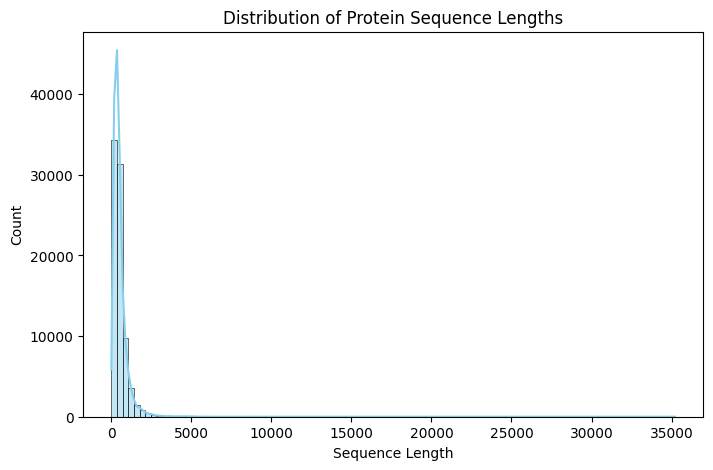

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


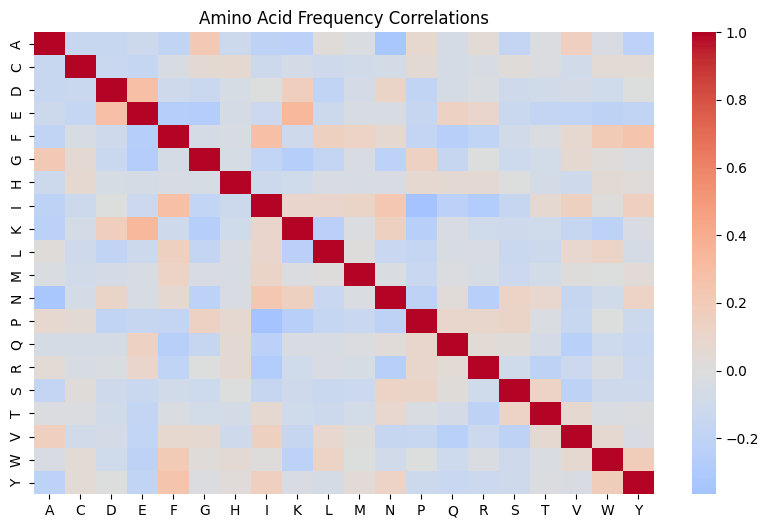

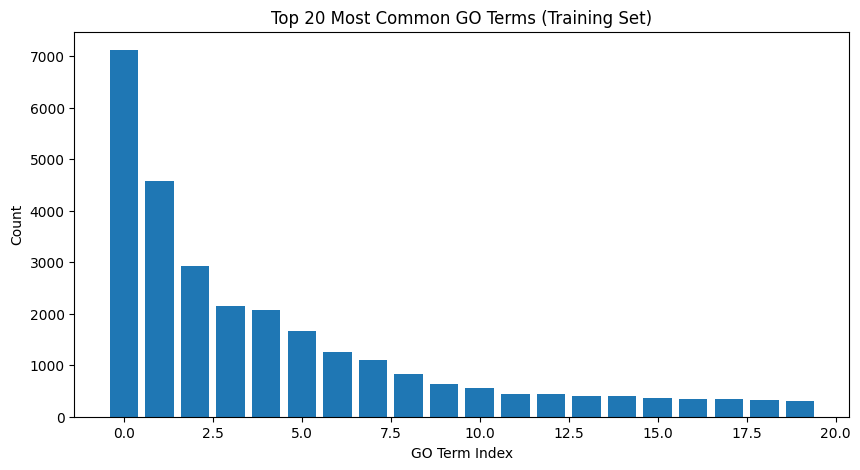

Average label density: 0.0001
Average number of GO terms per protein: 1.00


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1️⃣ Sequence length distribution ---
plt.figure(figsize=(8,5))
sns.histplot(seq_labeled['Length'], bins=100, color='skyblue', kde=True)
plt.title('Distribution of Protein Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.show()

# --- 2️⃣ Amino-acid composition heatmap ---
aa_cols = list("ACDEFGHIKLMNPQRSTVWY")
plt.figure(figsize=(10,6))
sns.heatmap(seq_labeled[aa_cols].corr(), cmap='coolwarm', center=0)
plt.title('Amino Acid Frequency Correlations')
plt.show()

# --- 3️⃣ Top 20 most frequent GO terms ---
go_counts = np.array(y_train.sum(axis=0)).flatten()
top_idx = np.argsort(go_counts)[-20:][::-1]

plt.figure(figsize=(10,5))
plt.bar(range(20), go_counts[top_idx])
plt.title('Top 20 Most Common GO Terms (Training Set)')
plt.xlabel('GO Term Index')
plt.ylabel('Count')
plt.show()

# --- 4️⃣ Label density ---
density = go_counts.mean() / y_train.shape[0]
print(f"Average label density: {density:.4f}")
print(f"Average number of GO terms per protein: {y_train.sum()/y_train.shape[0]:.2f}")


In [48]:
# ========================================
# 🧠 Step B2: LightGBM Multi-label Baseline
# ========================================

import lightgbm as lgb
from sklearn.metrics import f1_score
import numpy as np

# --- Configuration ---
NUM_LABELS = 300  # Use first 300 GO terms for faster training (you can increase later)
print(f"Training LightGBM on {NUM_LABELS} GO terms...")

# Subset labels
y_train_sub = y_train[:, :NUM_LABELS]
y_val_sub = y_val[:, :NUM_LABELS]

# --- Train a separate LightGBM model per label ---
micro_preds = []
micro_truths = []

for i in range(NUM_LABELS):
    y_col = y_train_sub[:, i]
    if y_col.sum() == 0:
        continue  # skip labels with no positives

    train_data = lgb.Dataset(X_train, label=y_col)

    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "num_leaves": 31,
        "learning_rate": 0.05,
        "feature_fraction": 0.8,
    }

    model = lgb.train(params, train_data, num_boost_round=50)

    # Predict
    y_pred_val = model.predict(X_val)
    y_pred_bin = (y_pred_val > 0.5).astype(int)

    micro_preds.extend(y_pred_bin)
    micro_truths.extend(y_val_sub[:, i])

# --- Evaluate ---
micro_f1 = f1_score(micro_truths, micro_preds, average="micro")
macro_f1 = f1_score(micro_truths, micro_preds, average="macro")

print(f"\n✅ LightGBM Baseline Complete!")
print(f"Micro F1: {micro_f1:.4f}")
print(f"Macro F1: {macro_f1:.4f}")


Training LightGBM on 300 GO terms...

✅ LightGBM Baseline Complete!
Micro F1: 0.9981
Macro F1: 0.5004


In [49]:
model = lgb.train(params, train_data)


In [50]:
model.feature_importance()


array([287, 123, 111, 117, 106, 100, 134, 116,  94,  72, 154, 100,  88,
       176,  79, 118,  91, 149, 144, 210], dtype=int32)

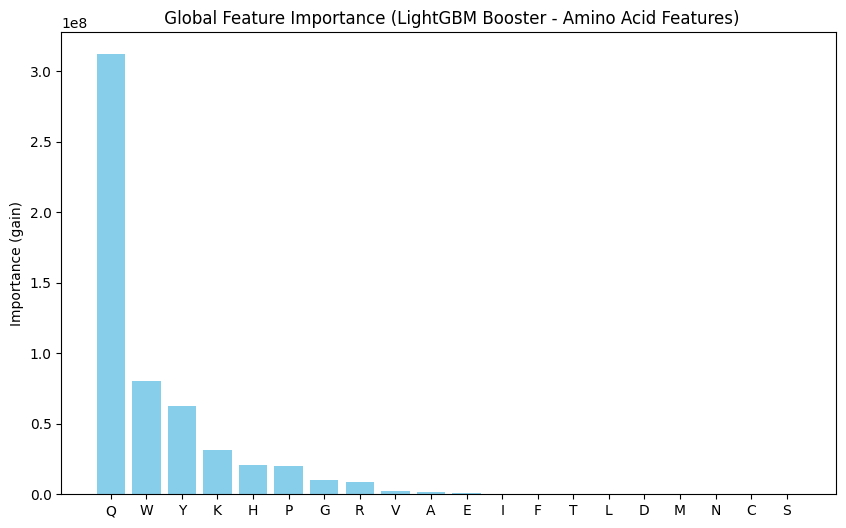

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the Booster
importance = model.feature_importance(importance_type='gain')

# Feature names (20 amino acids)
features = list("ACDEFGHIKLMNPQRSTVWY")

# Sort
sorted_idx = np.argsort(importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), importance[sorted_idx], color="skyblue")
plt.xticks(range(len(features)), np.array(features)[sorted_idx])
plt.ylabel("Importance (gain)")
plt.title(" Global Feature Importance (LightGBM Booster - Amino Acid Features)")
plt.show()


Text(0.5, 1.0, 'Global Feature Importance (LightGBM Booster - Amino Acid Features)')

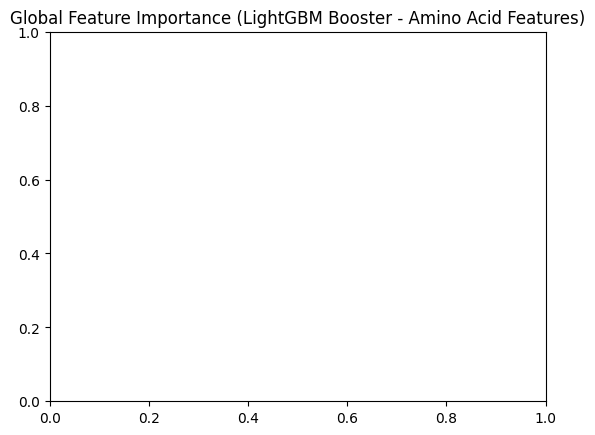

In [52]:
plt.title("Global Feature Importance (LightGBM Booster - Amino Acid Features)")


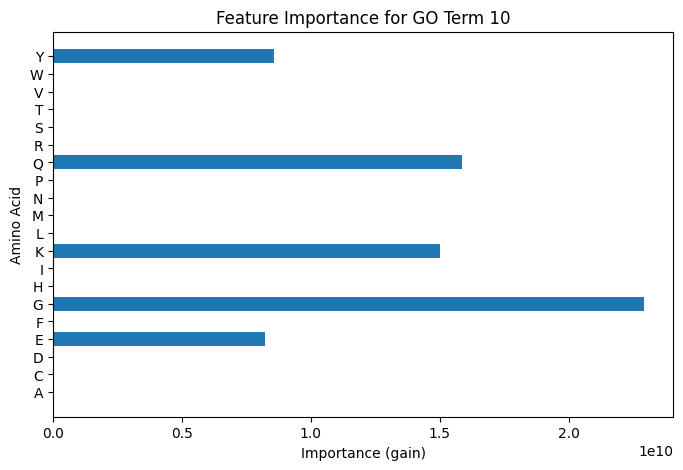

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

# Pick one GO term index to inspect (e.g., 10th)
target_idx = 10  

# Prepare data
dtrain = lgb.Dataset(X_train, label=y_train[:, target_idx])
dval = lgb.Dataset(X_val, label=y_val[:, target_idx], reference=dtrain)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'seed': 42
}

# ✅ Train (no verbose_eval, no early stopping)
booster = lgb.train(
    params,
    dtrain,
    valid_sets=[dval],
    num_boost_round=100
)

# --- Feature importances ---
importance = booster.feature_importance(importance_type='gain')
aa_cols = list("ACDEFGHIKLMNPQRSTVWY")

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.barh(aa_cols, importance)
plt.xlabel("Importance (gain)")
plt.ylabel("Amino Acid")
plt.title(f"Feature Importance for GO Term {target_idx}")
plt.show()


In [54]:
import pandas as pd
import numpy as np

# Use a smaller subset of GO terms to make it manageable
top_n_terms = 50  # adjust based on memory
y_subset = y_train[:, :top_n_terms]

# Compute co-occurrence matrix
co_occurrence = np.dot(y_subset.T, y_subset)

# Convert to DataFrame for easier plotting
go_labels = [f"GO:{i:07d}" for i in range(top_n_terms)]
co_matrix = pd.DataFrame(co_occurrence, index=go_labels, columns=go_labels)

print("Co-occurrence matrix shape:", co_matrix.shape)
co_matrix.head()


Co-occurrence matrix shape: (50, 50)


,GO:0000000,GO:0000001,GO:0000002,GO:0000003,GO:0000004,GO:0000005,GO:0000006,GO:0000007,GO:0000008,GO:0000009,GO:0000010,GO:0000011,GO:0000012,GO:0000013,GO:0000014,GO:0000015,GO:0000016,GO:0000017,GO:0000018,GO:0000019,GO:0000020,GO:0000021,GO:0000022,GO:0000023,GO:0000024,GO:0000025,GO:0000026,GO:0000027,GO:0000028,GO:0000029,GO:0000030,GO:0000031,GO:0000032,GO:0000033,GO:0000034,GO:0000035,GO:0000036,GO:0000037,GO:0000038,GO:0000039,GO:0000040,GO:0000041,GO:0000042,GO:0000043,GO:0000044,GO:0000045,GO:0000046,GO:0000047,GO:0000048,GO:0000049
GO:0000000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:0000001,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:0000002,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:0000003,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:0000004,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


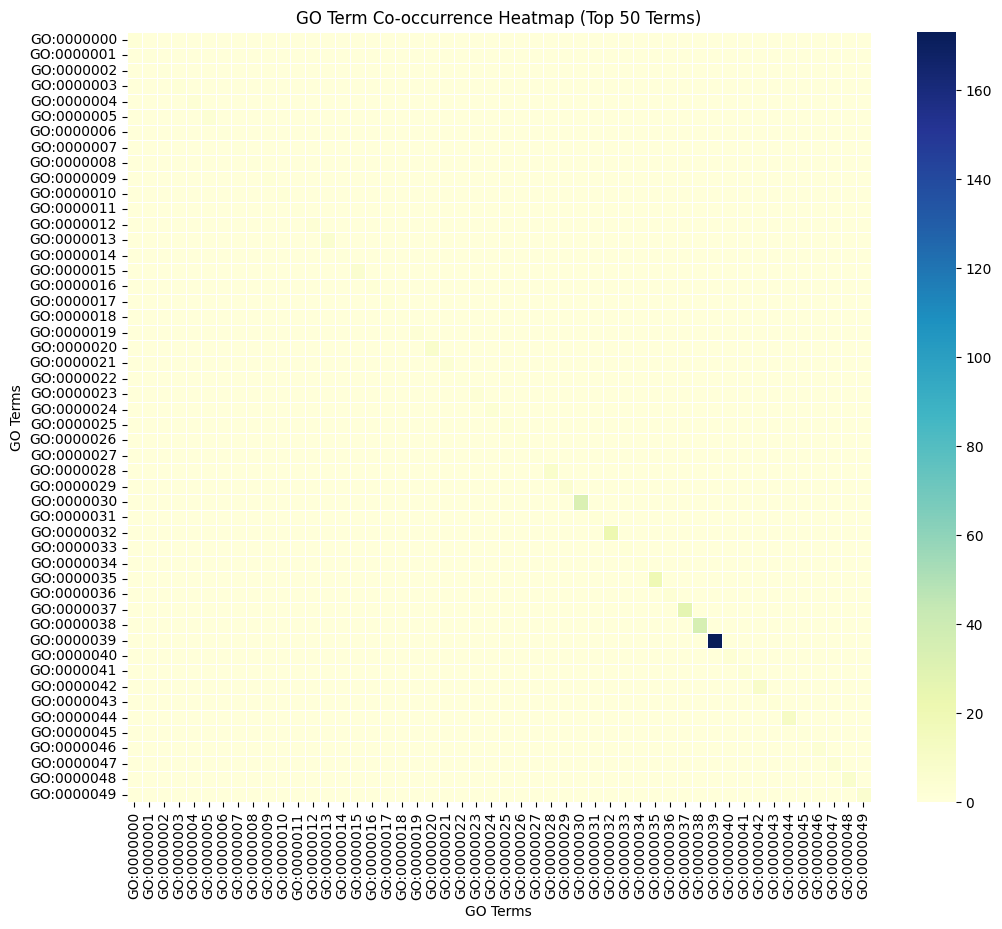

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(co_matrix, cmap="YlGnBu", linewidths=0.5)
plt.title("GO Term Co-occurrence Heatmap (Top 50 Terms)")
plt.xlabel("GO Terms")
plt.ylabel("GO Terms")
plt.show()


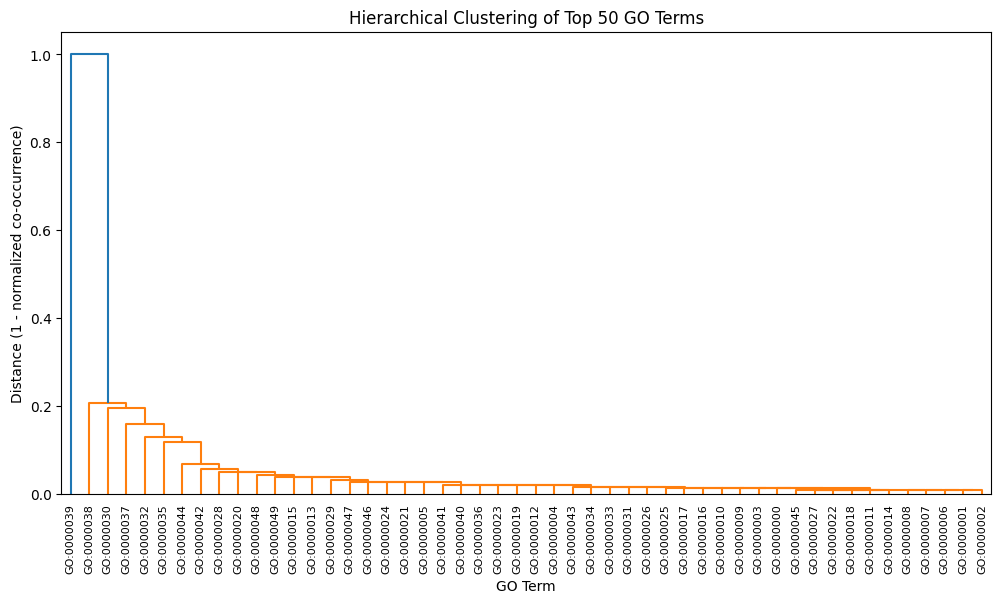

In [56]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Compute linkage matrix (distance = 1 - correlation)
# Normalize co-occurrence to correlation-like scale
norm_matrix = co_matrix / np.max(co_matrix.values)
distance_matrix = 1 - norm_matrix

# Perform hierarchical clustering
linked = linkage(distance_matrix, method='average')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=co_matrix.index, leaf_rotation=90)
plt.title("Hierarchical Clustering of Top 50 GO Terms")
plt.xlabel("GO Term")
plt.ylabel("Distance (1 - normalized co-occurrence)")
plt.show()


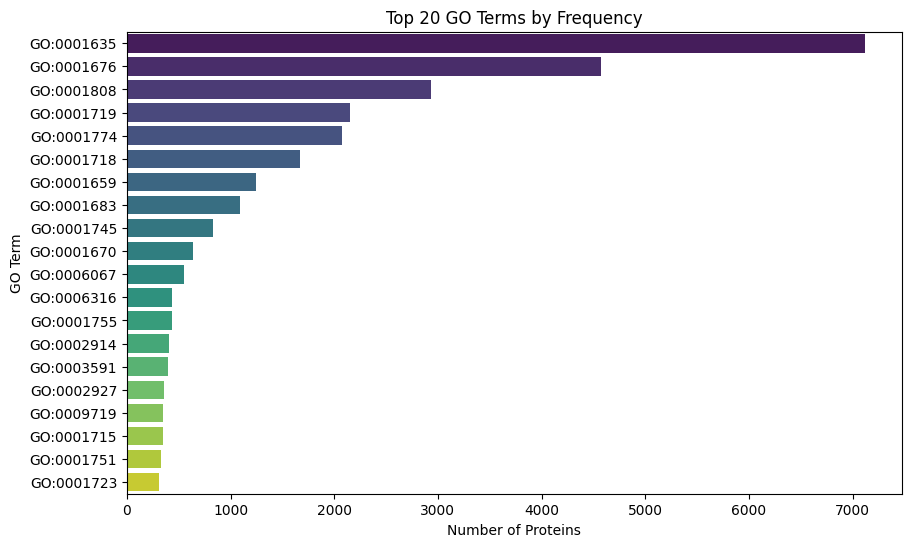

In [57]:
# Count frequency of each GO term in y_train
go_counts = y_train.sum(axis=0)  # sum across proteins

# Create a DataFrame for plotting
top_n = 20  # top 20 GO terms
top_indices = np.argsort(go_counts)[-top_n:][::-1]  # indices of top counts
top_go_terms = [f"GO:{i:07d}" for i in top_indices]
top_counts = go_counts[top_indices]

top_df = pd.DataFrame({"GO Term": top_go_terms, "Count": top_counts})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="GO Term", data=top_df, palette="viridis")
plt.title(f"Top {top_n} GO Terms by Frequency")
plt.xlabel("Number of Proteins")
plt.ylabel("GO Term")
plt.show()


In [58]:
# We'll use a manageable subset of GO terms (e.g., top 20 frequent)
top_indices = np.argsort(y_train.sum(axis=0))[-20:][::-1]
y_subset = y_train[:, top_indices]
go_labels_subset = [f"GO:{i:07d}" for i in top_indices]

# Compute average amino acid frequencies per GO term
aa_cols = list("ACDEFGHIKLMNPQRSTVWY")
aa_by_go = pd.DataFrame(index=aa_cols, columns=go_labels_subset)

for i, go_idx in enumerate(top_indices):
    # select proteins with this GO term
    proteins_with_go = X_train[y_subset[:, i] == 1]
    if len(proteins_with_go) > 0:
        aa_by_go.iloc[:, i] = proteins_with_go.mean(axis=0)
    else:
        aa_by_go.iloc[:, i] = 0

aa_by_go = aa_by_go.astype(float)
aa_by_go.head()


,GO:0001635,GO:0001676,GO:0001808,GO:0001719,GO:0001774,GO:0001718,GO:0001659,GO:0001683,GO:0001745,GO:0001670,GO:0006067,GO:0006316,GO:0001755,GO:0002914,GO:0003591,GO:0002927,GO:0009719,GO:0001715,GO:0001751,GO:0001723
A,0.073470,0.066748,0.083804,0.076968,0.078014,0.067629,0.080468,0.071618,0.066054,0.070314,0.083928,0.072024,0.066236,0.074088,0.081495,0.067595,0.094309,0.065079,0.068399,0.077639
C,0.020757,0.017764,0.019366,0.016708,0.025640,0.018693,0.034420,0.018638,0.017090,0.035661,0.017699,0.015706,0.018085,0.016144,0.021624,0.012862,0.021885,0.013806,0.017701,0.014363
D,0.051407,0.056225,0.042875,0.045577,0.054183,0.054422,0.047937,0.050284,0.045532,0.048865,0.053221,0.049103,0.050399,0.051432,0.043346,0.035828,0.038845,0.056687,0.044161,0.040827
E,0.072666,0.071769,0.049168,0.061462,0.069186,0.072001,0.046777,0.074779,0.056363,0.059763,0.069483,0.060620,0.064658,0.064754,0.053186,0.050929,0.063623,0.080007,0.052872,0.056936
F,0.036519,0.036004,0.046915,0.041506,0.035918,0.039411,0.043373,0.032621,0.055551,0.037065,0.035238,0.031169,0.046740,0.042558,0.045124,0.057222,0.030781,0.034408,0.056381,0.044529


In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(aa_by_go, annot=True, cmap="YlOrBr", fmt=".2f")
plt.title("Average Amino Acid Composition per GO Term (Top 20)")
plt.xlabel("GO Term")
plt.ylabel("Amino Acid")
plt.show()


In [59]:
top_n = 50
top_indices = np.argsort(y_train.sum(axis=0))[-top_n:][::-1]
y_subset = y_train[:, top_indices]
go_labels_subset = [f"GO:{i:07d}" for i in top_indices]

# Co-occurrence matrix
cooc_matrix = np.dot(y_subset.T, y_subset)
cooc_df = pd.DataFrame(cooc_matrix, index=go_labels_subset, columns=go_labels_subset)
print("Co-occurrence matrix shape:", cooc_df.shape)


Co-occurrence matrix shape: (50, 50)


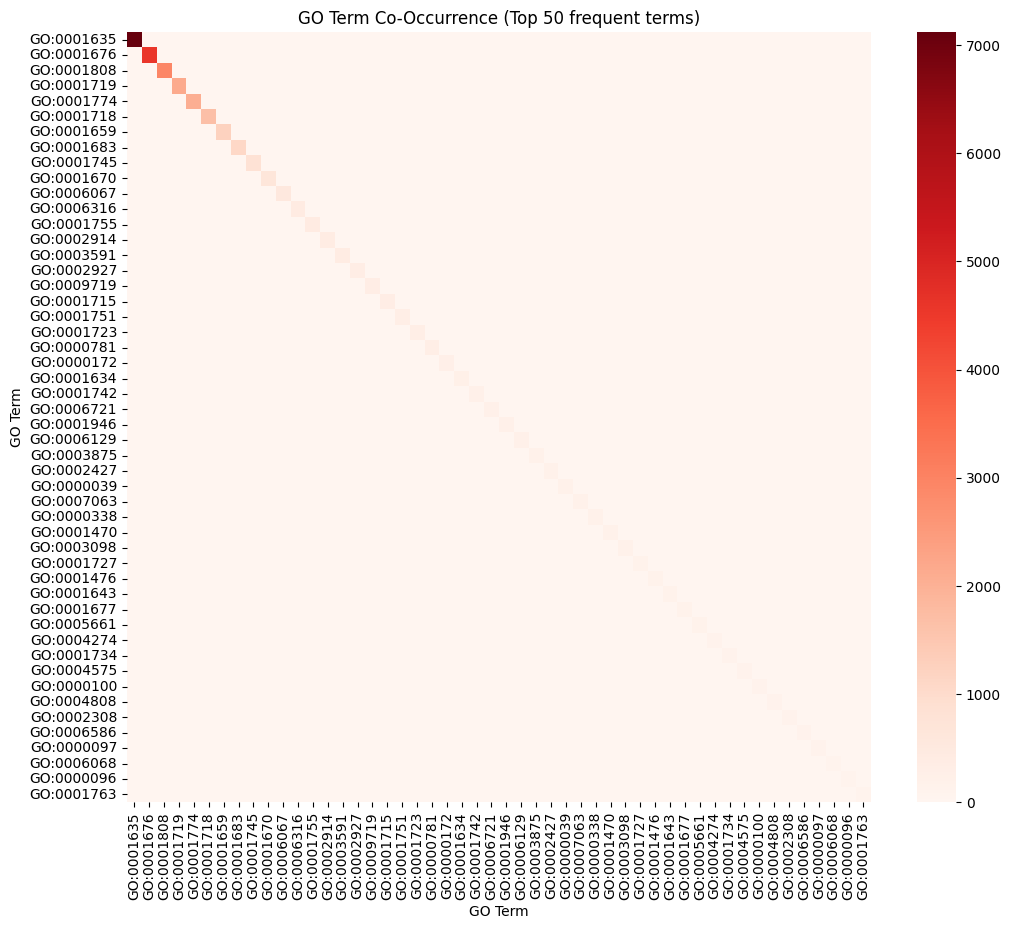

In [60]:
plt.figure(figsize=(12, 10))
sns.heatmap(cooc_df, cmap="Reds")
plt.title(f"GO Term Co-Occurrence (Top {top_n} frequent terms)")
plt.xlabel("GO Term")
plt.ylabel("GO Term")
plt.show()


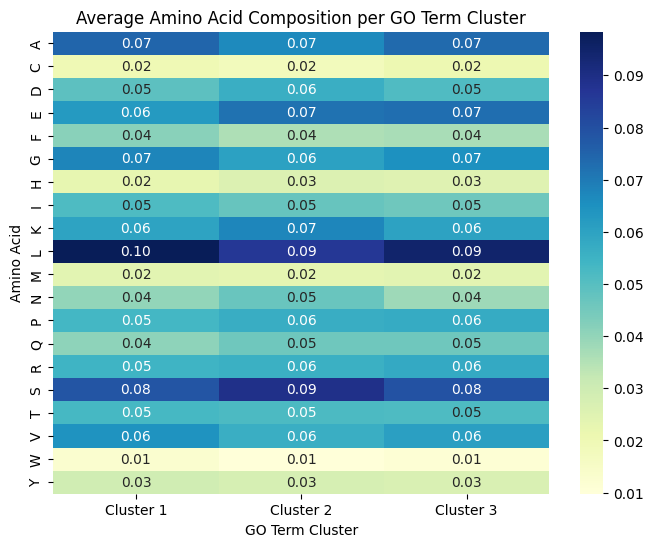

In [61]:
# Example: Use hierarchical clustering to find 3 clusters
from scipy.cluster.hierarchy import linkage, fcluster

# Perform clustering on co-occurrence
linkage_matrix = linkage(cooc_matrix, method='ward')
clusters = fcluster(linkage_matrix, t=3, criterion='maxclust')

aa_cols = list("ACDEFGHIKLMNPQRSTVWY")
aa_cluster_df = pd.DataFrame(index=aa_cols, columns=[f"Cluster {i}" for i in range(1, 4)])

for cluster_id in range(1, 4):
    # proteins in this cluster
    go_in_cluster = np.where(clusters == cluster_id)[0]
    proteins_in_cluster = y_subset[:, go_in_cluster].sum(axis=1) > 0  # proteins with any GO term in cluster
    aa_cluster_df[f"Cluster {cluster_id}"] = X_train[proteins_in_cluster].mean(axis=0)

aa_cluster_df = aa_cluster_df.astype(float)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(aa_cluster_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Average Amino Acid Composition per GO Term Cluster")
plt.xlabel("GO Term Cluster")
plt.ylabel("Amino Acid")
plt.show()


Advanced Feature Engineering for Proteins

We’ll tackle this step by step so it’s easy to follow.

1️⃣ Sequence k-mer Features

Idea:

A k-mer is a substring of length k from a protein sequence (like "ACD" for k=3).

k-mers capture local sequence motifs, which are often critical for function.

Implementation example: k=3